# Synopsis

We run PCA and HCA on the Federelist Papers using SKLearn to do our preprocessing. We bypass Pandas and friends for sake of speed, since we are not interested in creating an "edition" of the texts here. If we wanted to experiment with the effects of NLP preprocessing decisions and also wanted to interact with the contents of the files, we would consider using our standard approach to corpus ingestion and modeling.

# Configuration

In [2]:
source_dir = 'vierthaler-stylometry/fedpapers'
use_idf = True
# stop_words = None
stop_words = 'english'
max_features = 1000
n_components = 10

# Libraries

In [17]:
import glob
import re

# For PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# For HCA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

# For Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.colors

# Pragmas

In [4]:
%matplotlib inline

# Process

## Import the files into lists

In [5]:
files = glob.glob(source_dir+'/*.txt')
codes = [f.replace('.txt','').split('/')[-1].split('_') for f in files]
texts = [open(f, 'r', encoding='utf-8').read() for f in files]

In [62]:
titles = [re.sub(r'\n+', ' ', text.strip())[:80] for text in texts]
titles = [re.sub(r'The Same Subject Continued \(', '', title)[:40] for title in titles]

## Use SKL to create TFIDF matrix

In [24]:
countVectorizer = TfidfVectorizer(max_features=max_features, use_idf=use_idf, stop_words=None)
countMatrix1 = countVectorizer.fit_transform(texts)

## Normalize matrix 

In [25]:
countMatrix = normalize(countMatrix1)
countMatrix = countMatrix.toarray()

## PCA

### Generate PCA

In [26]:
pca = PCA(n_components=n_components)
projected = pca.fit_transform(countMatrix)

### Plot PCA

In [27]:
authors = [code[1] for code in codes]
letters = list(set(authors))
author_ids = [letters.index(x) for x in authors]

In [28]:
def plot_pca(proj, pc_a=0, pc_b=1):
    plt.figure(figsize=(15,10))
    plt.scatter(proj[:, pc_a], 
                proj[:, pc_b],
                c=author_ids, 
                edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Reds', 10))
    plt.xlabel('PC{}'.format(pc_a))
    plt.ylabel('PC{}'.format(pc_b))
    for i, x in enumerate(projected):
        plt.annotate(codes[i][1][:1], (x[pc_a], x[pc_b]))

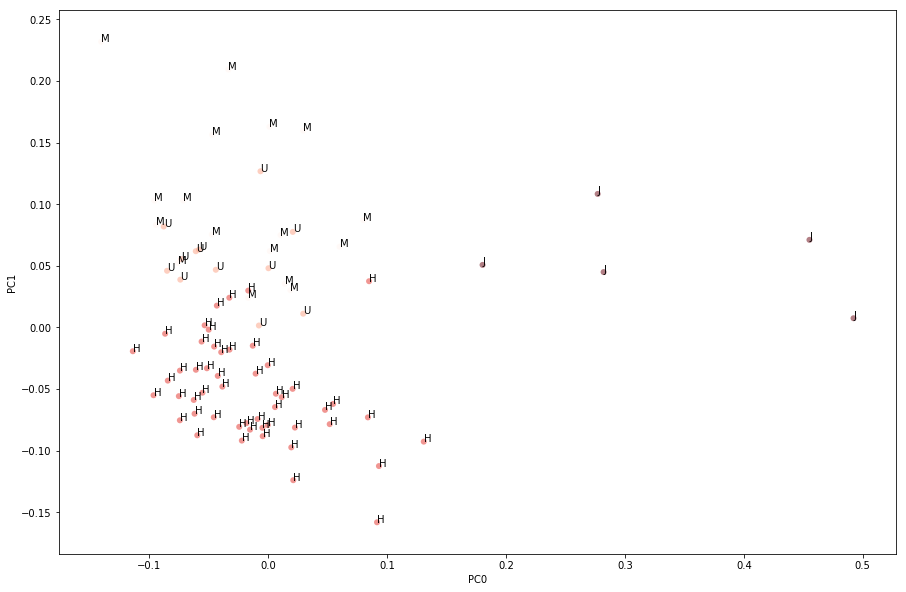

In [29]:
plot_pca(projected, 0, 1)

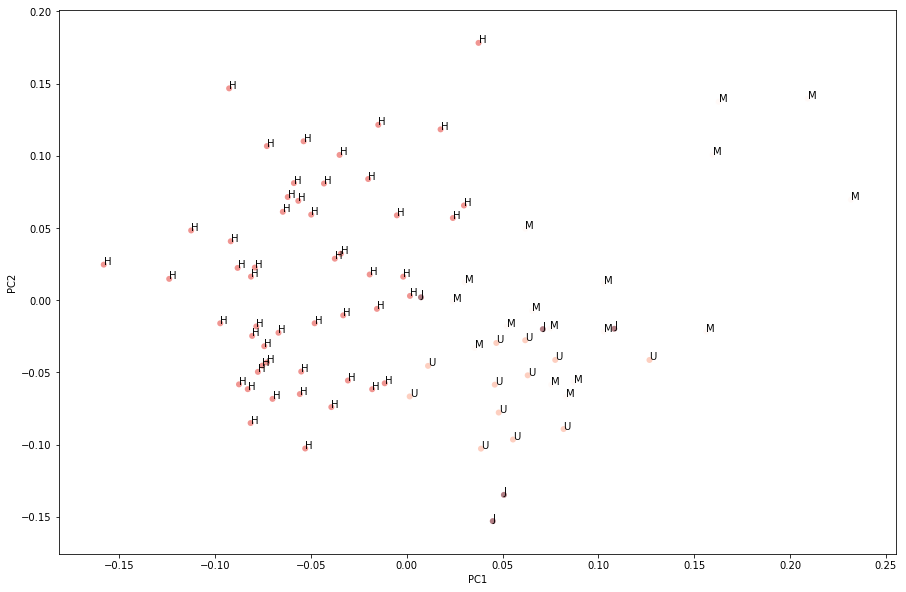

In [30]:
plot_pca(projected, 1, 2)

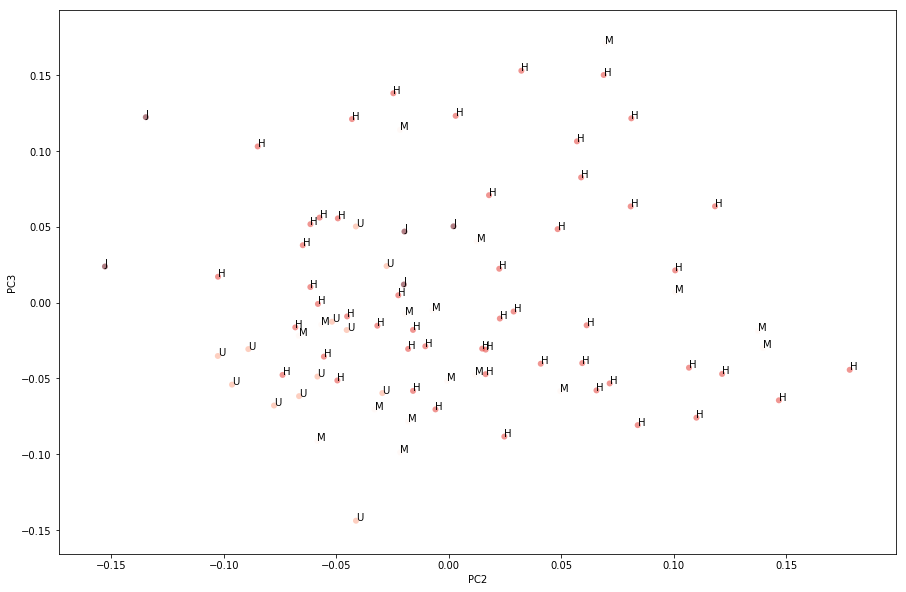

In [31]:
plot_pca(projected, 2, 3)

## HCA

### Generate similarity matrix

In [32]:
SIMS = pdist(countMatrix, metric='cosine')

### Generate HCA tree

In [33]:
TREE = sch.linkage(SIMS, method='ward')

### Plot tree

In the digrams, the length of the two legs of the U-link represents the distance between the child clusters.  It is also the
cophenetic distance between original observations in the two children clusters.

In [34]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, 60))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", distance_sort=True)
    plt.tick_params(axis='both', which='major', labelsize=18)

In [65]:
labels = ["{}. {}: {}".format(code[1], code[0], title) for code, title in zip(codes, titles)]

<Figure size 432x288 with 0 Axes>

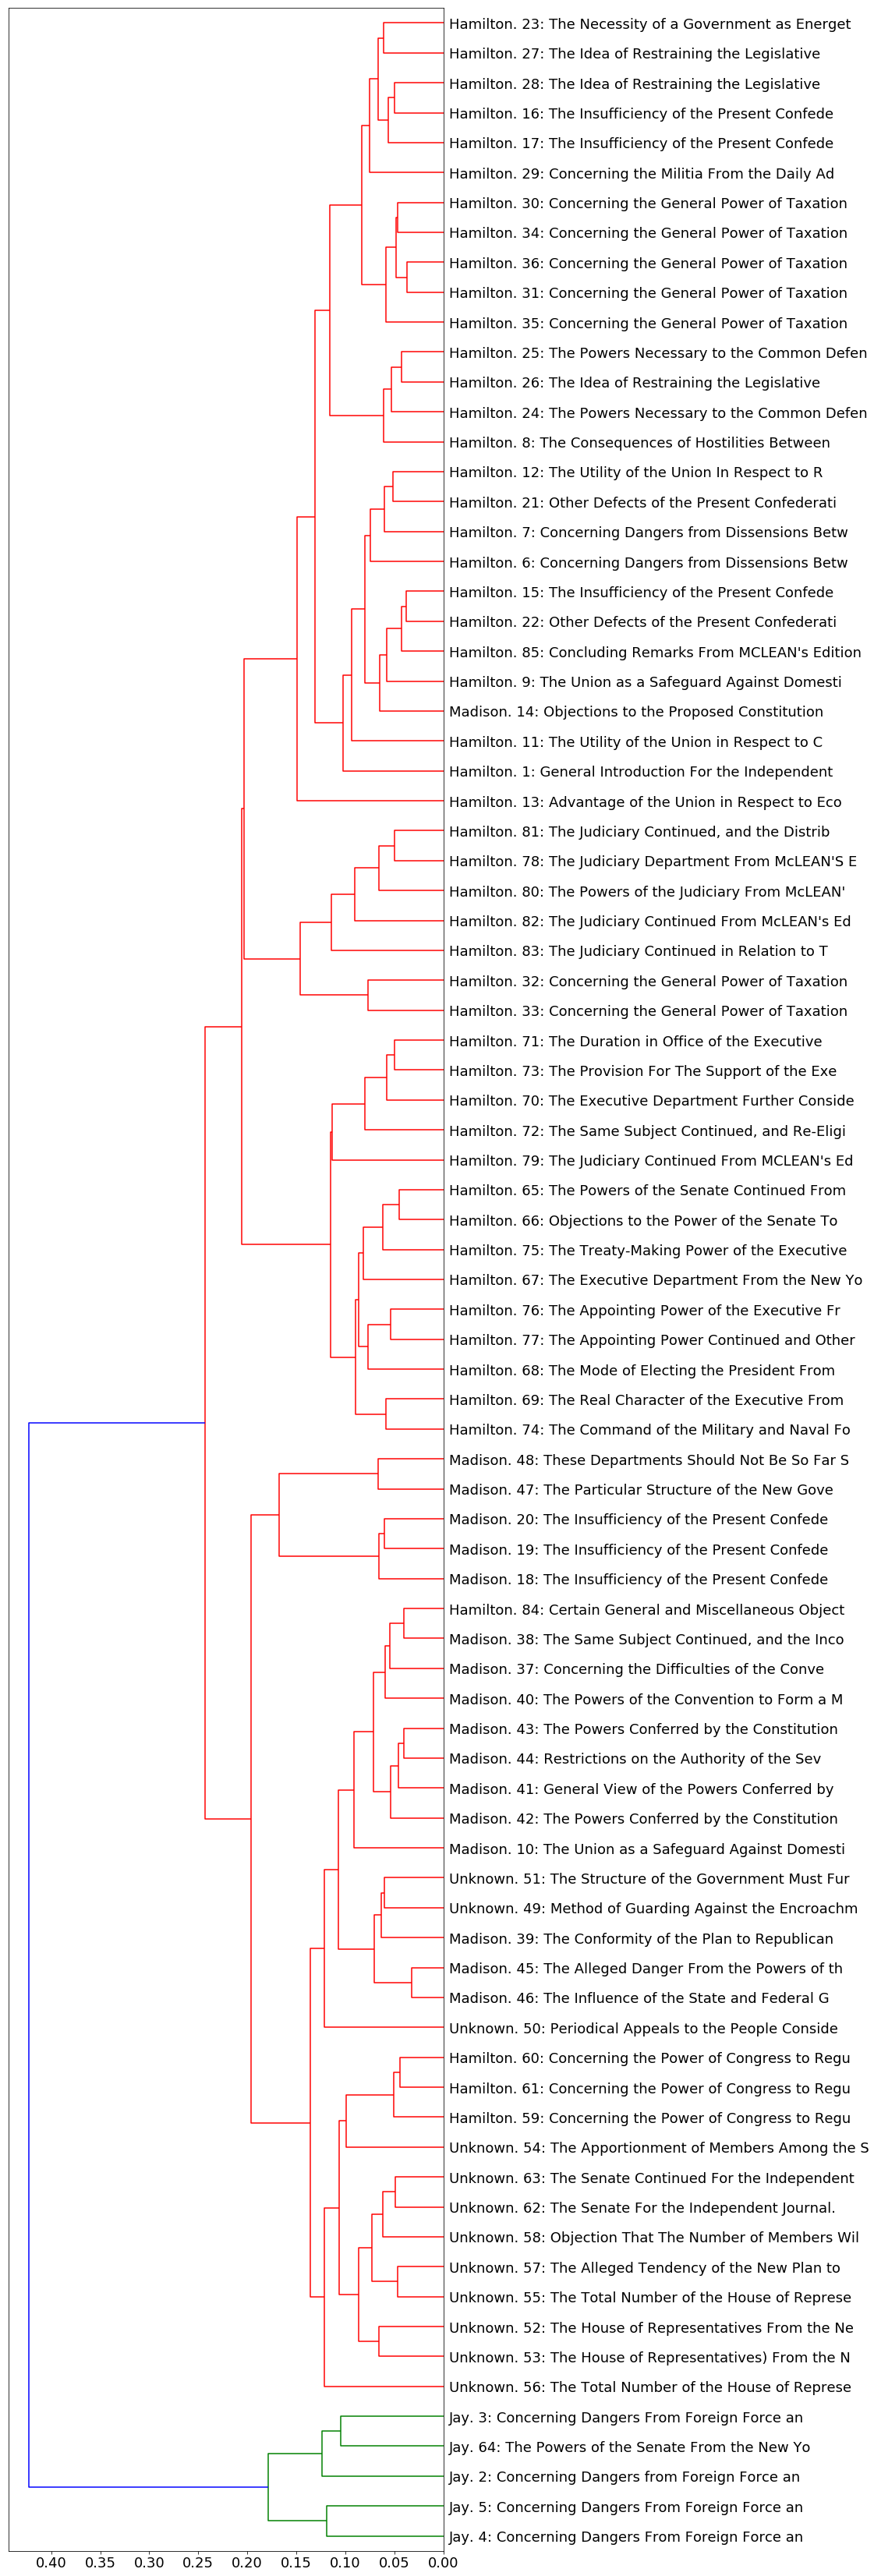

In [66]:
plot_tree(TREE, labels)

## The "Answers"

See [Wikipedia](https://en.wikipedia.org/wiki/The_Federalist_Papers#Authorship)

* Alexander Hamilton (51 articles: No. 1, 6–9, 11–13, 15–17, 21–36, 59–61, and 65–85)
* James Madison (29 articles: No. 10, 14, 18–20,[11] 37–58 and 62–63)
* John Jay (5 articles: No. 2–5 and 64).

In [ ]:
# END